# First ICU Prediction using Random Forests

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from utils.splits import set_two_splits
from utils.metrics import BinaryAvgMetrics
from utils.plots import *
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/work_dir/rf'),
 'dataset_csv': PosixPath('../data/processed_dataset.csv'),
 'cols': ['class_label', 'scispacy_note'],
 'modeldir': PosixPath('../data/work_dir/rf/models'),
 'min_freq': 3,
 'bc_threshold': 0.32,
 'start_seed': 127}

## Functions

In [3]:
def top_words(feature_names, probs, N):
  words = sorted(zip(probs, feature_names), reverse=True)
  pos = words[:N]
  neg = words[:-(N + 1):-1]

  print("Words associated with imminent threat: ")
  for feat in pos:
    print(np.round(feat[0], 2), feat[1])

  print("***********************************************")
  print("Words associated with not imminent threat: ")   
  for feat in neg:
    print(np.round(feat[0], 2), feat[1])

## RF Model Dev

In [4]:
seed = 42
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols)
df = set_two_splits(ori_df.copy(), 'test', seed=seed)

vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True,\
                              ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])
y_train = df.loc[(df['split'] == 'train')]['class_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['class_label'].to_numpy()

In [5]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1,\
                             min_samples_leaf=3, max_features=0.5, oob_score=True)
clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

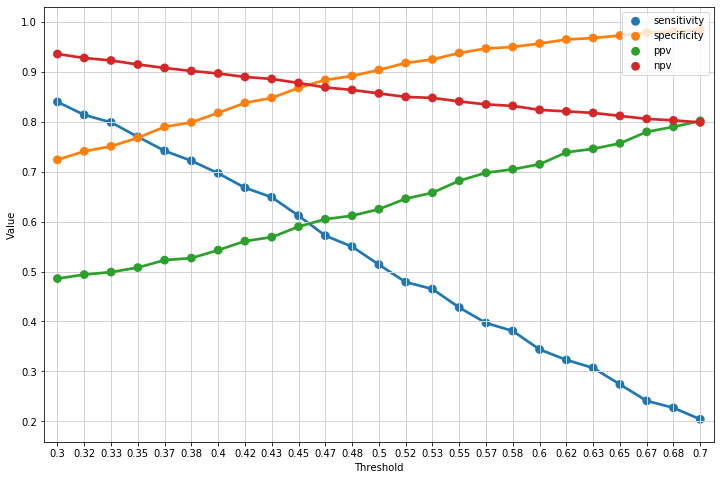

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, y_test, prob, 0.3, 0.7, 25)

In [7]:
y_pred = (prob > 0.32).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.814
specificity,0.741
ppv,0.494
npv,0.928
f1,0.615
auroc,0.858
prevalence,0.237


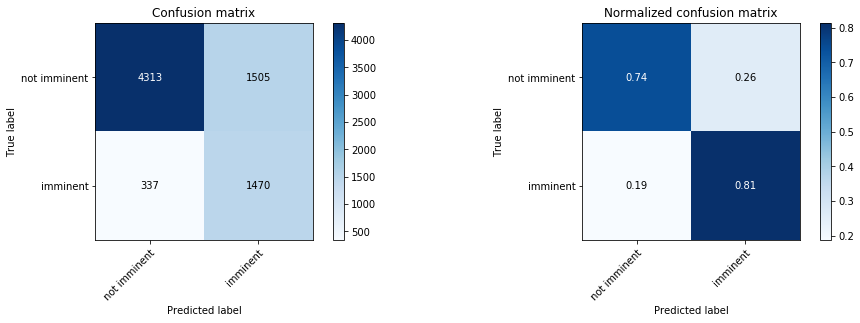

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_confusion_matrix(ax[0], cm, classes=['not imminent', 'imminent'], normalize=False, title='Confusion matrix')
plot_confusion_matrix(ax[1], cm, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized confusion matrix')
plt.show()

In [9]:
top_words(vectorizer.get_feature_names(), clf.feature_importances_, 20)

Words associated with imminent threat: 
0.08 _
0.03 Radiology
0.03 REPORT
0.03 Transfer
0.02 Clip
0.01 intubated
0.01 floor
0.01 tube
0.01 Number
0.01 vent
0.01 LAT
0.01 transfer
0.0 FINAL
0.0 PA
0.0 ,
0.0 of
0.0 .
0.0 and
0.0 home
0.0 with
***********************************************
Words associated with not imminent threat: 
0.0 
0.0 $
0.0 're
0.0 've
0.0 (+)-
0.0 (+)BOWEL
0.0 (+)BS
0.0 (+)BSx4
0.0 (+)CHF--
0.0 (+)GIB
0.0 (+)bowel
0.0 (+)bs
0.0 (+)palpable
0.0 (-).He
0.0 (-)1L
0.0 (-)500
0.0 (-)500cc
0.0 (-)BM
0.0 (-)DVT
0.0 (2)Rhythm


## Full Run

In [ ]:
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols)
preds = []
targs = []
probs = []

for seed in range(args.start_seed, args.start_seed + 100):
  if seed % 10 == 0:
    print(f"Running classifier with seed {seed}")
  df = set_two_splits(ori_df.copy(), 'test', seed=seed)
  vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, ngram_range=(2,2))
  
  x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
  x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])
  
  y_train = df.loc[(df['split'] == 'train')]['class_label'].to_numpy()
  y_test = df.loc[(df['split'] == 'test')]['class_label'].to_numpy()
  targs.append(y_test)
  
  clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1,\
                             min_samples_leaf=3, max_features=0.5, oob_score=True)
  clf.fit(x_train, y_train)  
  pickle.dump(clf, open(args.modeldir/f'lr_seed_{seed}.pkl', 'wb'))
  
  prob = clf.predict_proba(x_test)[:, 1]
  probs.append(prob)
  
  y_pred = (prob > args.bc_threshold).astype(np.int64)
  preds.append(y_pred)

with open(args.workdir/f'preds.pkl', 'wb') as f:
  pickle.dump(targs, f)
  pickle.dump(preds, f)
  pickle.dump(probs, f)

## Metrics

Taken from [here](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/):

1. Prevalence: `(fn + tp) / total`
2. Sensitivity: AKA recall, true positive rate `tp / (tp + fn)`
3. Specificity: AKA true negative rate `tn / (tn + fp)`
4. Positive Predictive Value (PPV): AKA precision `tp / (tp + fp)`
5. Negative Predictive Value (NPV): `tn / (tn + fn)`

In [ ]:
with open(args.workdir/f'preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

In [ ]:
bam = BinaryAvgMetrics(targs, preds, probs)
bam

In [ ]:
bam.get_avg_metrics()

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()